### Mobilnets Implementation

Previous versions I used max pooling for dimensionality reduction. In this version I'll substute a Conv2d, 1x1 layer instead; reduced to 15 channels from 1024. That will allow the 1x1 to learn the object shapes while the subsequent layer learns the classes.

#### 2017-09-17
Got this version working. There is some confusion on a few classes; notably person to cat or dog. Retraining should clear this up since there were several photos in the training set (since removed) where people would appear in other classes.

Also, I need to examine whether training is needed for the 0 class (background). Ideally, this class is never represented in the generator and only the relevant classes are shown.


In [1]:
'''
Created on Aug 22, 2017

@author: jyarde
'''
from keras import backend as K
from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D
from keras.models import load_model, Model, Sequential
from keras.optimizers import RMSprop, Adam, SGD
from keras.engine.topology import Layer
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from keras.layers import Input, Activation, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2DTranspose, UpSampling2D
from keras.layers.core import Reshape, Dropout
from keras.layers.core import Lambda

from PIL import Image, ImageDraw, ImageFont, ImageOps
import tensorflow as tf

import cv2
from ImageProcessing import get_viewport
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from CameraOperations import show_grid

def run_prediction(x):
    prediction = model.predict(x, 1, True)
    return prediction


def read_config(config_file="./imagenet1000_clsid_to_human_array.json"):
    '''
      Read Configuration parameters from external file
    '''
    import json
    
    with open(config_file) as config_data:
        config = json.load(config_data)
    return config


def predict_with_mobilenet(image, model=None):
    if model is None:
        model = load_model('./mobilenet_1_0_224_tf_local.h5', 
                           custom_objects={'relu6': relu6, 'DepthwiseConv2D': DepthwiseConv2D})
    image_input = image/255.
    X = np.expand_dims(image_input, 0)
    prediction = model.predict(X, len(X), False)
    idx = np.argmax(prediction, 1)[0]
    return idx, prediction, model

def save_channels(prediction, classes=1000):
    max_prob = np.max(prediction)
    print("\n{: >3.0f} ".format(0), end="")
    for r in range(classes):
        prediction_img = prediction[0][:,:,r]*255/max_prob
        cv2.imwrite("./deconv/img{}.jpg".format(r), prediction_img)
        '''
        if r>0 and not r%10:
            term = "\n{: >3.0f} ".format(int(r/10))
        else:
            term = ","
        #print("{1: >6.2f}/{0: >4.2f}".format(np.max(prediction[0][:,:,r]),np.sum(prediction[0][:,:,r])), end=term)
        print("{0: >6.2f}".format(np.max(prediction[0][:,:,r])/np.sum(prediction[0][:,:,r])), end=term)
        '''

def deconv_layer(inputs, 
                 filters, 
                 alpha=1.0, 
                 kernel=(3, 3), 
                 strides=(2, 2), 
                 block_id=1, 
                 activation=None, 
                 use_bias=True):
    '''
        Deconvolutional layers
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2DTranspose(filters, kernel,
               padding='valid',
               use_bias=use_bias,
               strides=strides,
               name='deconv_%d' % block_id,
               kernel_initializer='he_normal',
               bias_initializer='zeros')(inputs)
    #x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
    if activation is None:
        return Activation(relu6, name='deconv_relu_%d' % block_id)(x)
    else:
        return activation(x)

    
def conv_layer(inputs, 
               filters, 
               alpha=1.0, 
               kernel=(3, 3), 
               strides=(1, 1), 
               block_id=1, 
               activation=None, 
               use_bias=False,
               padding='valid'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2D(filters, kernel,
               padding=padding,
               use_bias=use_bias,
               strides=strides,
               name='t_conv_%d' % block_id,
               kernel_initializer='he_normal',
               bias_initializer='zeros')(inputs)
    x = BatchNormalization(axis=channel_axis, name='t_conv_bn_%d' % block_id)(x)
    if activation is None:
        return Activation(relu6, name='t_conv_relu_%d' % block_id)(x)
    else:
        return activation(x)

class CustomReshape(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomReshape, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        super(CustomReshape, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return tf.reshape(x, [-1, self.output_dim]) #np.reshape(x, (-1, 14)) 

    def compute_output_shape(self, input_shape):
        print("CustomReshape", input_shape)
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim}
        base_config = super(CustomReshape, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class BilinearUpSampling2D(Layer):

    def __init__(self, output_dim, scale_factor, **kwargs):
        self.output_dim   = output_dim
        self.scale_factor = scale_factor
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        super(BilinearUpSampling2D, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        input_size = tf.shape(x)
        size = (self.scale_factor*input_size[1], self.scale_factor*input_size[2])
        new_size = tf.convert_to_tensor(size, dtype=tf.int32)
        return tf.image.resize_images(x, new_size)
        #return tf.reshape(x, [-1, self.output_dim]) 

    def compute_output_shape(self, input_shape):
        print("BilinearUpSampling2D", input_shape)
        return input_shape[:-1] + (self.output_dim,)

    def get_config(self):
        config = {'output_dim': self.output_dim, 'scale_factor': self.scale_factor}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def generate_magic_kernel(classes=15, channels=15):
    magic_kernel = np.array([[0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25]])
    kernel = []
    for c in range(channels):
        kernel_channel
        for cl in range(classes):
            kernel_channel.append(magic_kernel)
        kernel.append(kernel_channel)
    return np.array(kernel)


def generate_2class_mobilenet(source_model, classes=2, deconv=True, dropout=1e-3):
    '''
        Reduce Mobilenet output classes to 2 so it can be trained on Kitti data
    '''
    w_final_conv2d = source_model.get_layer("conv_preds").get_weights()
    
    # Create a new top to take any size input
    new_input = Input(shape=(None, None, 3))
    #new_input = Input(shape=(256, 256, 3))
    
    '''
        Remove top and add Conv2D layers for reduction and recognition
    '''
    mobilenet = MobileNet(include_top=False, 
                      weights='imagenet', 
                      input_tensor=new_input)

    x = mobilenet.layers[-1].output
    #x = Dropout(dropout, name='dropout_final')(x)
    act = Activation('softmax', name='act_softmax')
    x = conv_layer  (x, 
                     classes, 
                     alpha=1.0, 
                     kernel=(3, 3), 
                     strides=(1, 1), 
                     padding='same',
                     block_id=1, 
                     activation=act)
    #x = Lambda(lambda a: print(a.shape))(x)
    x = MaxPooling2D(pool_size=(8, 8), strides=(8, 8))(x)
    x = CustomReshape(classes, name='reshape_2')(x)
    #compose the combined model with the new top
    new_model = Model(mobilenet.input, x)
    for i in range(len(new_model.layers)-5):
        new_model.layers[i].trainable = False

    new_model.summary()
    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    new_model.save('mobilenet_2class_model_updated.h5')
    return new_model


def generate_2class_fcn(source_model, classes=2, deconv=True, dropout=1e-3):
    '''
        Make Mobilenet fully convolutional with any size input and
        segmentation output. source_model provides fully loaded Mobilenet 
        so we can extract its weights for the FCN model
        
        Return the fully convolutional model.
    '''
    x = source_model.layers[-3].output
    sig = Activation('softmax', name='act_softmax2')
    trainable_layers = 0
    if deconv:
        x = BilinearUpSampling2D(scale_factor=4, output_dim=classes, name='upscore_1')(x)
        block_id = 1
        x = Conv2DTranspose(classes, 
                            (2, 2), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(1,1), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 2
        x = BilinearUpSampling2D(scale_factor=4, output_dim=classes, name='upscore_2')(x)
        x = Conv2DTranspose(classes, 
                            (2, 2), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(1,1), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 3
        x = Conv2DTranspose(classes, 
                            (4, 4), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)

        trainable_layers = 8
    else:
        x = UpSampling2D(size=2, data_format='channels_last')(x)

    #
    #compose the combined model with the new top
    new_model = Model(source_model.input, x)
    for i in range(len(new_model.layers) - trainable_layers):
        new_model.layers[i].trainable = False    
    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    new_model.summary()
    return new_model


def preprocess_image(image, normalize=False, pad=0):
    '''
    Normalize is divide by 255.
    pad is pad to multiples of 'pad'
    '''
    w = image.shape[1]
    h = image.shape[0]
    img = None
    if pad > 0:
        w_pad = pad - (w % pad)
        h_pad = pad - (h % pad)
        img = np.lib.pad(image, ((h_pad,0),(w_pad,0),(0,0)), 'constant', constant_values=(0,0))
    #else:
    #    img = np.asarray(image)
    if normalize:
        img = img/255.
    return img


def load_img(file, normalize=False, pad=0):
    '''
     Load images and always convert to RGB representation
     If 'normalize' is True, then divide by 255.
     If 'pad' is more than 0, pad the image to a multiple of the provided number
    '''
    image = Image.open(file)
    if image.mode is not 'RGB':
        image = image.convert('RGB')
    return preprocess_image(np.asarray(image), normalize, pad)


def pad_image(image, thickness=(1,1), padding=(1,1)):
    return np.lib.pad(image, thickness, 'constant', constant_values=padding)


def predict_with_model(image, model=None):
    image_input = image
    X = np.expand_dims(image_input, 0)
    prediction = model.predict(X, len(X), True)
    idx = np.argmax(prediction)
    return idx, prediction


def prediction_heatmaps(image, model, classes=2):
    result = predict_with_model(image, model)
    #result = None
    #image_input = image/255.
    #X = np.expand_dims(image_input, 0)
    #prediction = model.predict(X, 1, False)
    #pred = prediction[0]
    pred = result[1][0]
    heatmap = np.concatenate([pad_image(pred[:,:,c], thickness=(1,1)) for c in range(classes)], axis=1)
    return heatmap

'''
conv_model = Model(segmenter.input, segmenter.layers[-6].output)
'''

def extract_heatmap_class(heatmap, classid, classes=2):
    frame_width = heatmap.shape[1]/classes
    start = int(classid*frame_width)
    end   = int(start + frame_width)
    return heatmap[:,start:end]


def image_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    r = clahe.apply(image[:,:,0])
    g = clahe.apply(image[:,:,1])
    b = clahe.apply(image[:,:,2])
    
    return np.stack([r,g,b], -1)

def process_image(img_file, fcn, conv, targets=[0,1], pad=0, equalize=False):
    '''
    Show heatmaps for image targets from deconvolutional model and pure fully convolutional model
    targets is a list of class ids to show
    '''
    img = load_img(img_file, normalize=False, pad=pad)
    if equalize:
        img = image_clahe(img)
        
    print("Image Dimensions", img.shape)
    target_fcn = None
    
    if fcn is not None:
        heatmap = prediction_heatmaps(img/255., fcn)
        plt.figure(figsize=(15,2))
        p = plt.imshow(heatmap, cmap="hot")
        print("Heatmap Dimensions", heatmap.shape)
        names = [class_names[n] for n in targets]
        names.insert(0, "Source")
        target_fcn = [extract_heatmap_class(heatmap, c) for c in targets]
        target_fcn.insert(0, img)
        show_grid(target_fcn, names, cmap_mono="hot")

    if conv is not None:
        heatmap = prediction_heatmaps(img/255., conv)
        plt.figure(figsize=(15,2))
        p = plt.imshow(heatmap, cmap="hot")
        print("Heatmap Dimensions", heatmap.shape)
        names = [class_names[n] for n in targets]
        names.insert(0, "Source")
        target = [extract_heatmap_class(heatmap, c) for c in targets]
        target.insert(0, img)
        show_grid(target, names, cmap_mono="hot")
    return target_fcn


input_size = (256,256)
fcn_size   = (512,512)
classes    = 2
model_file = "./training/classifier_72-0.838-0.029.hdf5"
fcn_model_file = "./training/test/fcn_weights_03-0.965-0.031.hdf5"
class_names = ["background", "road"]

'''
mobilenet_model = load_model('./mobilenet_1_0_224_tf_local.h5', 
                             custom_objects={'relu6': relu6, 
                                             'DepthwiseConv2D': DepthwiseConv2D})

classifier = load_model(model_file, 
                        custom_objects={'relu6': relu6, 
                                        'DepthwiseConv2D': DepthwiseConv2D, 
                                        'CustomReshape': CustomReshape})

fcn_model = load_model(fcn_model_file, 
                       custom_objects={'relu6': relu6, 
                                       'DepthwiseConv2D': DepthwiseConv2D, 
                                       'CustomReshape': CustomReshape, 
                                       'BilinearUpSampling2D': BilinearUpSampling2D})
'''

fcn_input = None
fcn_input = Input(shape=(None, None, 3))

mobilenetv1 = MobileNet(input_tensor=fcn_input, alpha=1.0, depth_multiplier=1, include_top=False, weights='imagenet', pooling=None, classes=1000)
mobilenetv1.summary()


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/applications/mobilenet.py:224: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
__________

### Add Skip Layers. Do Joint Training

Skip layers preserve location information so lets add one at a time and joint train the model on the 2-class output

In [2]:
import keras 

def generate_2class_skiplayer_fcn(source_model, classes=2, deconv=True, dropout=1e-3):
    '''
        Make Mobilenet fully convolutional with any size input and
        segmentation output. source_model provides fully loaded Mobilenet 
        so we can extract its weights for the FCN model
        
        Return the fully convolutional model.
    '''
    x = source_model.layers[-1].output #Last layer used from Mobilenet. Choosing the last convolution
    #x_channels = mobilenet.layers[-7].output_shape[-1]
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    '''    
    for i in range(len(source_model.layers) - 4):
        source_model.layers[i].trainable = False
    source_model.layers[-3].trainable = True
    trainable_layers = 16 # Train the deconvolutions
    '''

    bias_flag = True
    bias_init = 'he_normal'

    skip_id = 15
    skip_7 = source_model.layers[-skip_id].output
    skip_7_channels = source_model.layers[-skip_id].output_shape[-1]
    skip_7 = Conv2D(classes, (1,1),
               padding="same",
               use_bias=bias_flag,
               strides=(1,1),
               name='t_skip_conv_7',
               kernel_initializer='he_normal',
               bias_initializer=bias_init)(skip_7)
    
    skip_id = 57
    skip_5 = source_model.layers[-skip_id].output
    skip_5_channels = source_model.layers[-skip_id].output_shape[-1]
    skip_5 = Conv2D(classes, (1,1),
               padding="same",
               use_bias=bias_flag,
               strides=(1,1),
               name='t_skip_conv_5',
               kernel_initializer='he_normal',
               bias_initializer=bias_init)(skip_5)
    
    skip_id = 71
    skip_3 = source_model.layers[-skip_id].output
    skip_3_channels = source_model.layers[-skip_id].output_shape[-1]
    skip_3 = Conv2D(classes, (1,1),
               padding="same",
               use_bias=bias_flag,
               strides=(1,1),
               name='t_skip_conv_3',
               kernel_initializer='he_normal',
               bias_initializer=bias_init)(skip_3)
    
    sig = Activation('softmax', name='act_softmax2')
    bias_flag = True
    bias_init = 'he_normal'
    
    if deconv:
        block_id = 1
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            padding='same', 
                            activation='softmax',
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer=bias_init)(x)
        x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
        block_id = 2
        x_skip7 = keras.layers.Add()([x, skip_7])
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            padding='same', 
                            activation='softmax',
                            use_bias=bias_flag, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer=bias_init)(x_skip7)
        x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
        block_id = 3
        x_skip5 = keras.layers.Add()([x, skip_5])
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            padding='same', 
                            activation='softmax',
                            use_bias=bias_flag, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer=bias_init)(x_skip5)
        x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
        block_id = 4
        x_skip3 = keras.layers.Add()([x, skip_3])
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            padding='same',
                            activation='softmax',
                            use_bias=bias_flag, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer=bias_init)(x_skip3)
        x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
        block_id = 5
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            padding='same', 
                            activation='softmax',
                            use_bias=bias_flag, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer=bias_init)(x)
    else:
        x = Conv2D(classes, (1,1),
                   padding="same",
                   use_bias=bias_flag,
                   strides=(1,1),
                   activation='softmax',
                   name='t_reduce_channels_1',
                   kernel_initializer='he_normal',
                   bias_initializer=bias_init)(x)
        x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_1')(x)
        x_skip7 = keras.layers.Add()([x, skip_7])
        x = Conv2D(classes, (1,1),
                   padding="same",
                   use_bias=bias_flag,
                   strides=(1,1),
                   activation='softmax',
                   name='t_conv2d_smoothing_1',
                   kernel_initializer='he_normal',
                   bias_initializer=bias_init)(x_skip7)
        
        x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_2')(x)
        x_skip5 = keras.layers.Add()([x, skip_5])
        x = Conv2D(classes, (1,1),
                   padding="same",
                   use_bias=bias_flag,
                   strides=(1,1),
                   activation='softmax',
                   name='t_conv2d_smoothing_2',
                   kernel_initializer='he_normal',
                   bias_initializer=bias_init)(x_skip5)
        
        x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_3')(x)
        x_skip3 = keras.layers.Add()([x, skip_3])
        x = Conv2D(classes, (1,1),
                   padding="same",
                   use_bias=bias_flag,
                   strides=(1,1),
                   activation='softmax',
                   name='t_conv2d_smoothing_3',
                   kernel_initializer='he_normal',
                   bias_initializer=bias_init)(x_skip3)
        
        x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_4')(x)
        x = Conv2D(classes, (1,1),
                   padding="same",
                   use_bias=bias_flag,
                   strides=(1,1),
                   activation='softmax',
                   name='t_conv2d_smoothing_4',
                   kernel_initializer='he_normal',
                   bias_initializer=bias_init)(x)
        
        x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_5')(x)
        x = Conv2D(classes, (1,1),
                   padding="same",
                   use_bias=bias_flag,
                   strides=(1,1),
                   activation='softmax',
                   name='t_conv2d_smoothing_5',
                   kernel_initializer='he_normal',
                   bias_initializer=bias_init)(x)
        
        #x = UpSampling2D(size=2, data_format='channels_last')(x)

    #
    #compose the combined model with the new top
    new_model = Model(source_model.input, x)
    for i in range(len(new_model.layers)-22):
        new_model.layers[i].trainable = False

    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    new_model.summary()
    return new_model

#classifier = generate_2class_mobilenet(mobilenet_model, classes=2)
fcn_model  = generate_2class_skiplayer_fcn(mobilenetv1, deconv=False)


BilinearUpSampling2D (None, None, None, 2)
BilinearUpSampling2D (None, None, None, 2)
BilinearUpSampling2D (None, None, None, 2)
BilinearUpSampling2D (None, None, None, 2)
BilinearUpSampling2D (None, None, None, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 3 864         conv1_pad[0][0]                  
____________________________________________________________________________________________

### Visualize model

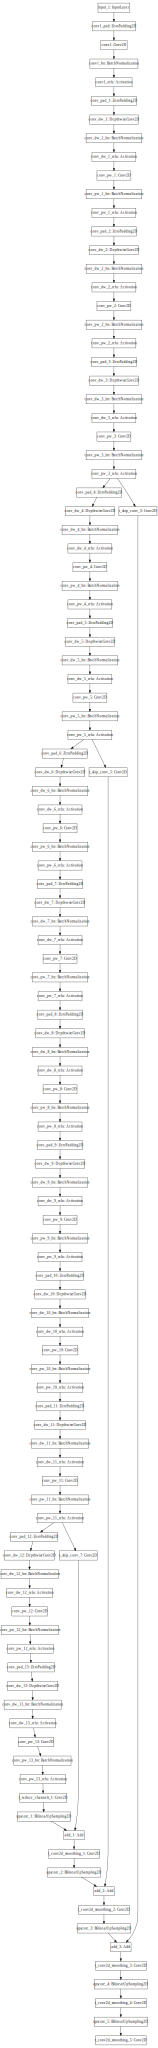

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils import plot_model
plot_model(fcn_model, to_file='/home/jyarde/mobilenet_model.png', show_shapes=True)


SVG(model_to_dot(fcn_model).create(prog='dot', format='svg'))

### Train the Fully-convolutional model



In [4]:
from fcnprocessing import ImageDataGenerator

#classifier = generate_2class_mobilenet(mobilenet_model, classes=2)
#fcn_model  = generate_2class_fcn(classifier, deconv=True)

def training_callbacks(folder="./training/", name_prefix="classifier_", batch=30, use_val=True):
    '''
    Generate callbacks to checkpoint model during training and reduce the learning rate on plateau
    'use_val' decides whether to use training or validation statistics for decisions and reporting
    '''
    #filepath = "./training/weights-improvement-{epoch:02d}-{val_acc:.3f}-{val_loss:.3f}.hdf5"
    filepath = folder+name_prefix+"{epoch:02d}-{val_acc:.3f}-{val_loss:.3f}.hdf5"
    monitor_checkpoint = 'val_acc'
    monitor_reduce_lr = 'val_loss'
    if not use_val:
        filepath = folder+name_prefix+"{epoch:02d}-{acc:.3f}-{loss:.3f}.hdf5"
        monitor_checkpoint = 'acc'
        monitor_reduce_lr = 'loss'
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor=monitor_checkpoint, 
                                 verbose=0, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor=monitor_reduce_lr, 
                                  factor=0.25, patience=3, 
                                  min_lr=0.00005, 
                                  mode='min', 
                                  verbose=0)
    tensorboard = TensorBoard(log_dir='./tensorboard', 
                              histogram_freq=0, 
                              batch_size=batch, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=False, 
                              embeddings_freq=0, 
                              embeddings_layer_names=None, 
                              embeddings_metadata=None)
    callbacks_list = [checkpoint, reduce_lr, tensorboard]
    return callbacks_list


# we create two instances with the same arguments
shift = 0.2
data_gen_args = dict(rescale=1./255,
                     horizontal_flip=True,
                     vertical_flip=True,
                     brightness=5,
                     channel_shift_range=32,
                     width_shift_range=shift,
                     height_shift_range=shift, 
                     data_format="channels_last")
'''
                     rotation_range=0)
                     shear_range=0.2,
                     zoom_range=0.2,
'''

image_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
root = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/"
#root = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_15/"
image_dir = root+"input/"
mask_dir  = root+"output/"
classes = 2
multiplier = 4
batch = 8

image_generator = image_datagen.flow_from_directory(image_dir,
                                                    class_mode='sparse_mask',
                                                    batch_size=batch,
                                                    seed=seed, 
                                                    target_size=(512, 512))

fcn_model.fit_generator(image_generator,
                        steps_per_epoch=256,
                        verbose=1,
                        epochs=10,
                        callbacks=training_callbacks(batch=batch, name_prefix="fcn_weights_", use_val=False))
fcn_model.save('fcn_classifier_model.hdf5')


Found 289 images belonging to 1 classes.
Epoch 1/10
256/256 [==============================] - 917s 4s/step - loss: 0.1361 - acc: 0.8418
Epoch 2/10
256/256 [==============================] - 906s 4s/step - loss: 0.1133 - acc: 0.8460
Epoch 3/10
256/256 [==============================] - 912s 4s/step - loss: 0.0761 - acc: 0.9201
Epoch 4/10
256/256 [==============================] - 903s 4s/step - loss: 0.0601 - acc: 0.9358
Epoch 5/10
256/256 [==============================] - 905s 4s/step - loss: 0.0503 - acc: 0.9465
Epoch 6/10
256/256 [==============================] - 916s 4s/step - loss: 0.0456 - acc: 0.9518
Epoch 7/10
256/256 [==============================] - 916s 4s/step - loss: 0.0426 - acc: 0.9552
Epoch 8/10
256/256 [==============================] - 900s 4s/step - loss: 0.0416 - acc: 0.9565
Epoch 9/10
256/256 [==============================] - 903s 4s/step - loss: 0.0395 - acc: 0.9591
Epoch 10/10
256/256 [==============================] - 921s 4s/step - loss: 0.0380 - acc: 0.960

### Model Testing

In [ ]:

fcn_model_file = "./training/fcn_weights_94-0.966-0.031.hdf5"
fcn_model = load_model(fcn_model_file, 
                        custom_objects={'relu6': relu6, 
                                        'DepthwiseConv2D': DepthwiseConv2D, 
                                        'CustomReshape': CustomReshape})



Image Dimensions (704, 1216, 3)
1/1 [==============================] - 1s 1s/step
Heatmap Dimensions (706, 2436)



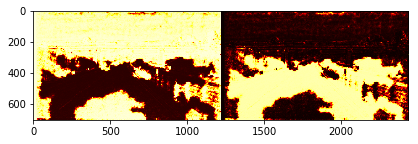

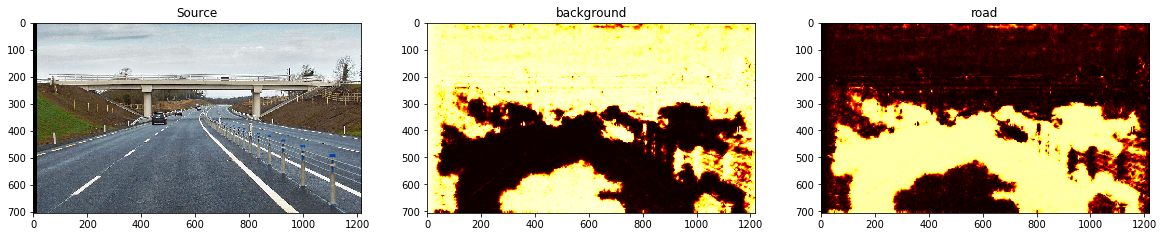

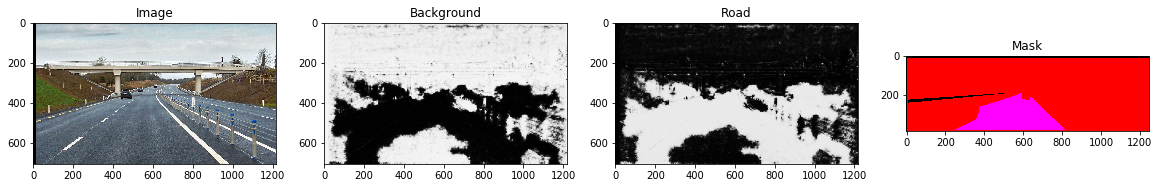

In [11]:
pad_len = 32
ask_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/output/1/um_road_000030.png"
img_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/testing/image_2/um_000030.png"

img_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/testing/image_2/um_000040.png"
mask_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/output/1/um_road_000040.png"

img_file = "/home/jyarde/Pictures/PO01RoadMain.jpeg"
img_file = "/home/jyarde/Pictures/N4_Dromad-Roosky_(bright_enhance_filter).jpg"

pad_len=32
img = load_img(img_file, normalize=False, pad=pad_len)

fcn_output = process_image(img_file, fcn_model, None, targets=[0,1], pad=pad_len, equalize=False)
img_mask = load_img(mask_file, normalize=False, pad=pad_len)
fcn_output.append(img_mask)
show_grid(fcn_output, ["Image", "Background", "Road", "Mask"])
print()

254

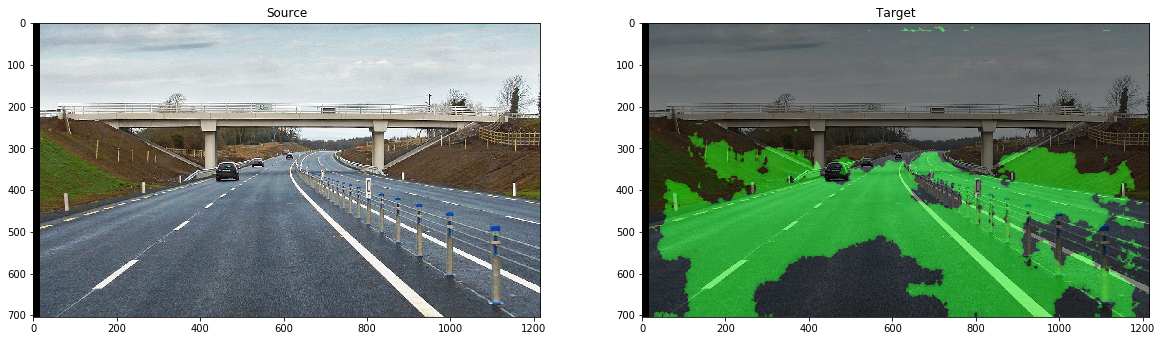

In [12]:
from ImageProcessing import weighted_img

#masked_img = weighted_img(img, img_mask, α=0.8, β=1., λ=0.)
#show_grid([img, masked_img], ["Source", "Target"])

threshold = 0.55
threshold_img = np.copy(fcn_output[2])
threshold_img[fcn_output[2] <= threshold] = 0

stacked_img = np.stack((threshold_img,)*3, -1)

stacked_img[:,:,0] = 0
stacked_img[:,:,2] = 0
shape = (img.shape[1],img.shape[0])
stacked_img = cv2.resize(stacked_img, shape, interpolation=cv2.INTER_AREA)
stacked_img = stacked_img * 255

#masked_img = weighted_img(img_mask.astype('int16'), stacked_img.astype('int16'), α=1., β=0.8, λ=0.)
#show_grid([img, masked_img], ["Source", "Target"])

masked_img = weighted_img(img.astype('uint16'), stacked_img.astype('uint16'), α=0.5, β=0.5, λ=0.0)
show_grid([img, masked_img], ["Source", "Target"])

np.max(masked_img)

### Apply to Video

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

idx=0
cache = None

def process_frame(frame, fcn, targets=[0,1], pad=32, threshold=0.95):
    '''
    Show heatmaps for image targets from deconvolutional model and pure fully convolutional model
    targets is a list of class ids to show
    '''
    #print(type(frame[0][0][0]))
    img = preprocess_image(frame, normalize=False, pad=pad)
    target_fcn = None
    heatmap = prediction_heatmaps(img/255., fcn)
    target_fcn = [extract_heatmap_class(heatmap, c) for c in targets]
    threshold_img = np.copy(target_fcn[1])
    threshold_img[target_fcn[1] <= threshold] = 0

    stacked_img = np.stack((threshold_img,)*3, -1)
    stacked_img[:,:,0] = 0
    stacked_img[:,:,2] = 0
    shape = (img.shape[1],img.shape[0])
    stacked_img = cv2.resize(stacked_img, shape, interpolation=cv2.INTER_AREA)
    stacked_img = stacked_img * 255
    masked_img = weighted_img(img.astype('uint8'), stacked_img.astype('uint8'), α=1.0, β=0.5, λ=0.0)
    return masked_img

img = None

def make_frame_lane_markings(image):
    global idx
    global fcn_model
    global img 
    annotated_image = process_frame(image, fcn_model, targets=[0,1], pad=32, threshold=0.55)
    idx = idx + 1
    img = image
    return annotated_image

clip_output = "./annotated_project_video.mp4" 
clip_handle = VideoFileClip("test_video.mp4", audio=False)
img_clip = clip_handle.fl_image(make_frame_lane_markings) 
img_clip.write_videofile(clip_output, audio=False)


1/1 [==============================] - 1s 1s/step


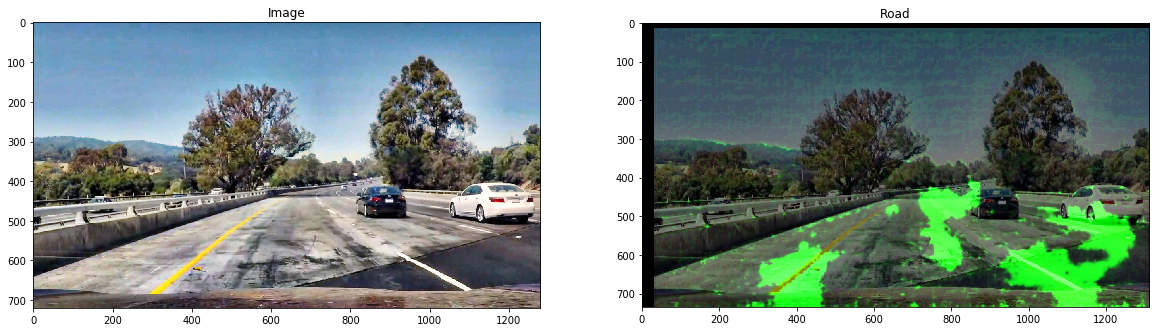

In [14]:
fcn_output = process_frame(image_clahe(img), fcn_model, targets=[0,1], pad=32, threshold=0.05) 
#process_image(img_file, fcn_model, None, targets=[0,1], pad=pad_len)
show_grid([image_clahe(img), fcn_output], ["Image", "Road"])


1/1 [==============================] - 1s 1s/step


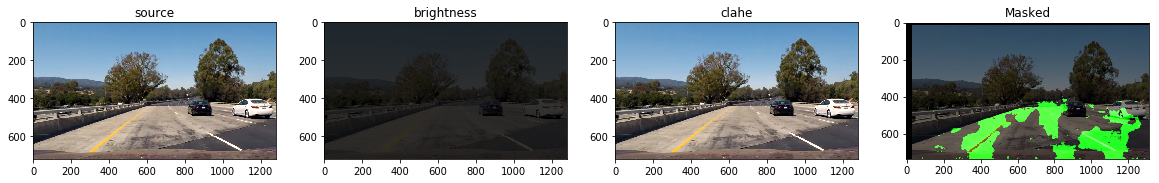

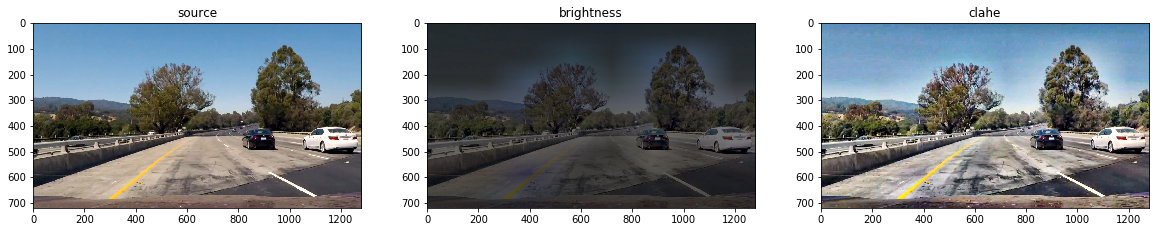

In [15]:
from ImageProcessing import image_brightness

def image_preprocessing(image):
    img = image.astype("uint8")
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def image_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    r = clahe.apply(image[:,:,0])
    g = clahe.apply(image[:,:,1])
    b = clahe.apply(image[:,:,2])
    
    return np.stack([r,g,b], -1)

show_grid( 
    [img, 
     image_brightness(img, phi=5, theta=1, maxIntensity=255.0), 
     img,
     process_frame(img, fcn_model, targets=[0,1], pad=32, threshold=0.55)], 
    ["source", "brightness", "clahe", "Masked"] )

show_grid( 
    [img, image_clahe(image_brightness(img, phi=5, theta=1, maxIntensity=255.0)), image_clahe(img)], 
    ["source", "brightness", "clahe"] )

#show_grid( [image_brightness(img, phi=phi) for phi in range(1,10)], [i for i in range(1,10)])

### Bulk Testing

In [ ]:
def process_folder(img_file, fcn, conv, targets=[0,1], pad=0, equalize=False):
    '''
    Show heatmaps for image targets from deconvolutional model and pure fully convolutional model
    targets is a list of class ids to show
    '''
    img = load_img(img_file, normalize=False, pad=pad)
    if equalize:
        img = image_clahe(img)
        
    print("Image Dimensions", img.shape)
    target_fcn = None
    
    if fcn is not None:
        heatmap = prediction_heatmaps(img/255., fcn)
        plt.figure(figsize=(15,2))
        p = plt.imshow(heatmap, cmap="hot")
        print("Heatmap Dimensions", heatmap.shape)
        names = [class_names[n] for n in targets]
        names.insert(0, "Source")
        target_fcn = [extract_heatmap_class(heatmap, c) for c in targets]
        target_fcn.insert(0, img)
        show_grid(target_fcn, names, cmap_mono="hot")

    if conv is not None:
        heatmap = prediction_heatmaps(img/255., conv)
        plt.figure(figsize=(15,2))
        p = plt.imshow(heatmap, cmap="hot")
        print("Heatmap Dimensions", heatmap.shape)
        names = [class_names[n] for n in targets]
        names.insert(0, "Source")
        target = [extract_heatmap_class(heatmap, c) for c in targets]
        target.insert(0, img)
        show_grid(target, names, cmap_mono="hot")
    return target_fcn

from CameraOperations import load_images_from_folder

folder = "./data/data_road/testing/image_2"
image_batch = load_images_from_folder(folder, images=None, name_pattern="um_00000*.png", pad=32)
show_grid(image_batch[:3], [i for i in range(len(image_batch[:3]))])
for i in range(len(image_batch)):
    print(image_batch[i].shape)